In [1]:
import sys
import os

sys.path.append('/dfs/scratch0/vschen/metal')
os.environ['METALHOME'] = '/dfs/scratch0/vschen/metal'

In [2]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Generate Data

In [4]:
seed = 312

import random
np.random.seed(seed)
random.seed(seed)

In [5]:
from simulate import data_config
from synthetics_utils import generate_synthetic_data
from visualization_utils import visualize_data, display_scores, plot_slice_scores, plot_predictions

from metal.end_model import EndModel
from metal.contrib.slicing.online_dp import LinearModule, MLPModule, SliceDPModel

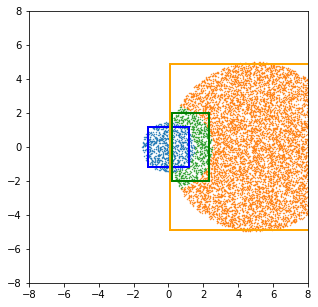

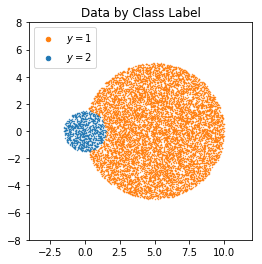

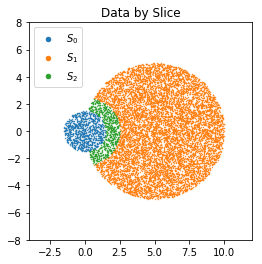

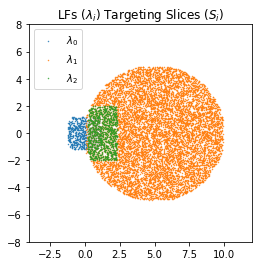

In [6]:
# from deathstar_data import generate_deathstar_data, generate_uniform_circle_data, get_circle_idx
from data_generators import generate_pacman_data
from synthetics_utils import shuffle_matrices, lf_circ_idx_for_slice_precision

config = {
    'N': 10000,
    'mus': np.array([[0,  0], [5, 0]]),
    'variances': [1.5, 5],
    'labels': [2, 1],
    'lf_metrics': [('recall', 1.0), ('recall', 1.0)],
}

X, Y, Z, L = generate_pacman_data(config, plotting=True)

visualize_data(X, Y, Z, L)

### Compare EndModel to AttentionModel

In [7]:
from metal.contrib.slicing.online_dp import MLPModule
from metal.contrib.slicing.metrics import calc_slice_acc, calc_heads_acc

RUN_NAME = 'pacman'

# NOTE: each model can take a "train_kwargs"

### SHARED PIECES
train_kwargs = {
    "n_epochs": 20,
    "lr": 0.001,
    "l2": 0,
    "log_unit": "epochs",
#     "log_train_metrics_func": None,
#     "log_train_metrics": ["loss"],
    "log_train_every": 1,
    "log_valid_every": 1,
    "log_valid_metrics_func": [calc_slice_acc],
    "log_valid_metrics": ["accuracy"],
    "checkpoint": True,
    "checkpoint_metric": "accuracy",
    "writer": "tensorboard",
    "log_dir": f"{os.environ['METALHOME']}/tensorboard/",
    "run_name": RUN_NAME,
}

end_model_init_kwargs = {
    "layer_out_dims": [2, 5, 5, 2],
}

### FULL CONFIGS
uni_config = {
    "end_model_init_kwargs": end_model_init_kwargs,
    "train_kwargs": train_kwargs
}

up_config = {
    "end_model_init_kwargs": end_model_init_kwargs,
    "upweight_search_space": {"range": [1, 5]},
    "max_search": 5,
    "train_kwargs": train_kwargs
}

moe_config = {
    "end_model_init_kwargs": end_model_init_kwargs,
    "expert_train_kwargs": {"n_epochs": 10, "verbose": False},
    "train_kwargs": {"verbose": False},
    "gating_dim": 5,
    "train_kwargs": train_kwargs
}

print("WARNING: Pay attention to slice weight!")


base_dp_config = {
    "end_model_init_kwargs": end_model_init_kwargs,
    "slice_kwargs": {
        "vanilla": True,
        "verbose": True,
    },
    "train_kwargs": train_kwargs
}

sm_dp_config = {
    "end_model_init_kwargs": end_model_init_kwargs,
    "slice_kwargs": {
        "L_weight": 0.1,
        "online_head": False,
        "indicator": True,
        "mask_abstains": False,
        "verbose": True,
    },
    "train_kwargs": train_kwargs
}

sm_on_config = {
    "end_model_init_kwargs": end_model_init_kwargs,
    "slice_kwargs": {
        "L_weight": 0.1,
        "Y_off_weight": 0.1,
        "online_head": True,
        "indicator": False,
        "mask_abstains": True,
        "verbose": True,
    },
    "train_kwargs": train_kwargs
}



Salt: 918880
Pepper: 0.1
[Trial 0]
---------- Training DP ----------
Added pepper=0.1 random negatives on 3/3 LFs

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
  )
  (2): Sequential(
    (0): Linear(in_features=5, out_features=5, bias=True)
    (1): ReLU()
  )
  (3): Linear(in_features=5, out_features=2, bias=True)
)

Default to SliceMaster
Overriding options to create vanilla EndModel.
Resetting base model parameters
SliceMaster(
  (body): Sequential(
    (0): IdentityModule()
    (1): Sequential(
      (0): Linear(in_features=2, out_features=5, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=5, out_features=5, bias=True)
      (1): ReLU()
    )
  )
  (Y_head_off): Linear(in_features=5, out_features=1, bias=True)
  (Y_criteria): BCEWithLogitsLoss()
)

[1 epo]: TRAIN:[loss=8.845] VALID:[slice_1=0.915, slice_2=0.907, accuracy=0.914]
Saving model

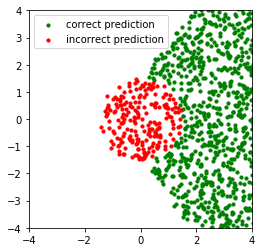

---------- Training SM_DP ----------
Added pepper=0.1 random negatives on 3/3 LFs

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
  )
  (2): Sequential(
    (0): Linear(in_features=5, out_features=5, bias=True)
    (1): ReLU()
  )
  (3): Linear(in_features=5, out_features=2, bias=True)
)

Default to SliceMaster
Resetting base model parameters
SliceMaster(
  (body): Sequential(
    (0): IdentityModule()
    (1): Sequential(
      (0): Linear(in_features=2, out_features=5, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=5, out_features=5, bias=True)
      (1): ReLU()
    )
  )
  (L_head): Linear(in_features=5, out_features=3, bias=False)
  (L_criteria): BCEWithLogitsLoss()
  (Y_head_off): Linear(in_features=5, out_features=1, bias=True)
  (Y_criteria): BCEWithLogitsLoss()
)

[1 epo]: TRAIN:[loss=10.578] VALID:[slice_1=0.915, slice_2=0.907, accuracy

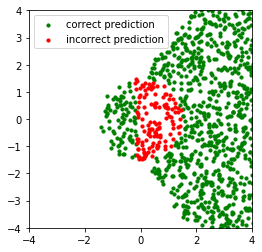

---------- Training SM_ON ----------
Added pepper=0.1 random negatives on 3/3 LFs

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
  )
  (2): Sequential(
    (0): Linear(in_features=5, out_features=5, bias=True)
    (1): ReLU()
  )
  (3): Linear(in_features=5, out_features=2, bias=True)
)

Default to SliceMaster
Resetting base model parameters
SliceMaster(
  (body): Sequential(
    (0): IdentityModule()
    (1): Sequential(
      (0): Linear(in_features=2, out_features=5, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=5, out_features=5, bias=True)
      (1): ReLU()
    )
  )
  (L_head): Linear(in_features=5, out_features=3, bias=False)
  (L_criteria): BCEWithLogitsLoss()
  (Y_head_off): Linear(in_features=5, out_features=1, bias=True)
  (Y_criteria): BCEWithLogitsLoss()
  (Y_head_on): Linear(in_features=5, out_features=1, bias=True)
)

[1 epo]: T

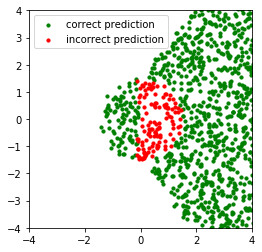

[Trial 1]
---------- Training DP ----------
Added pepper=0.1 random negatives on 3/3 LFs

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
  )
  (2): Sequential(
    (0): Linear(in_features=5, out_features=5, bias=True)
    (1): ReLU()
  )
  (3): Linear(in_features=5, out_features=2, bias=True)
)

Default to SliceMaster
Overriding options to create vanilla EndModel.
Resetting base model parameters
SliceMaster(
  (body): Sequential(
    (0): IdentityModule()
    (1): Sequential(
      (0): Linear(in_features=2, out_features=5, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=5, out_features=5, bias=True)
      (1): ReLU()
    )
  )
  (Y_head_off): Linear(in_features=5, out_features=1, bias=True)
  (Y_criteria): BCEWithLogitsLoss()
)

[1 epo]: TRAIN:[loss=15.972] VALID:[slice_1=0.915, slice_2=0.907, accuracy=0.914]
Saving model at iteration 1 with bes

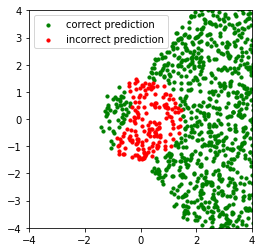

---------- Training SM_DP ----------
Added pepper=0.1 random negatives on 3/3 LFs

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
  )
  (2): Sequential(
    (0): Linear(in_features=5, out_features=5, bias=True)
    (1): ReLU()
  )
  (3): Linear(in_features=5, out_features=2, bias=True)
)

Default to SliceMaster
Resetting base model parameters
SliceMaster(
  (body): Sequential(
    (0): IdentityModule()
    (1): Sequential(
      (0): Linear(in_features=2, out_features=5, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=5, out_features=5, bias=True)
      (1): ReLU()
    )
  )
  (L_head): Linear(in_features=5, out_features=3, bias=False)
  (L_criteria): BCEWithLogitsLoss()
  (Y_head_off): Linear(in_features=5, out_features=1, bias=True)
  (Y_criteria): BCEWithLogitsLoss()
)

[1 epo]: TRAIN:[loss=7.911] VALID:[slice_1=0.915, slice_2=0.907, accuracy=

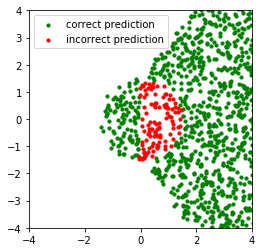

---------- Training SM_ON ----------
Added pepper=0.1 random negatives on 3/3 LFs

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
  )
  (2): Sequential(
    (0): Linear(in_features=5, out_features=5, bias=True)
    (1): ReLU()
  )
  (3): Linear(in_features=5, out_features=2, bias=True)
)

Default to SliceMaster
Resetting base model parameters
SliceMaster(
  (body): Sequential(
    (0): IdentityModule()
    (1): Sequential(
      (0): Linear(in_features=2, out_features=5, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=5, out_features=5, bias=True)
      (1): ReLU()
    )
  )
  (L_head): Linear(in_features=5, out_features=3, bias=False)
  (L_criteria): BCEWithLogitsLoss()
  (Y_head_off): Linear(in_features=5, out_features=1, bias=True)
  (Y_criteria): BCEWithLogitsLoss()
  (Y_head_on): Linear(in_features=5, out_features=1, bias=True)
)

[1 epo]: T

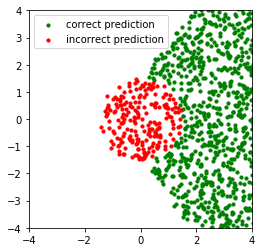

[Trial 2]
---------- Training DP ----------
Added pepper=0.1 random negatives on 3/3 LFs

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
  )
  (2): Sequential(
    (0): Linear(in_features=5, out_features=5, bias=True)
    (1): ReLU()
  )
  (3): Linear(in_features=5, out_features=2, bias=True)
)

Default to SliceMaster
Overriding options to create vanilla EndModel.
Resetting base model parameters
SliceMaster(
  (body): Sequential(
    (0): IdentityModule()
    (1): Sequential(
      (0): Linear(in_features=2, out_features=5, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=5, out_features=5, bias=True)
      (1): ReLU()
    )
  )
  (Y_head_off): Linear(in_features=5, out_features=1, bias=True)
  (Y_criteria): BCEWithLogitsLoss()
)

[1 epo]: TRAIN:[loss=20.319] VALID:[slice_1=0.915, slice_2=0.907, accuracy=0.914]
Saving model at iteration 1 with bes

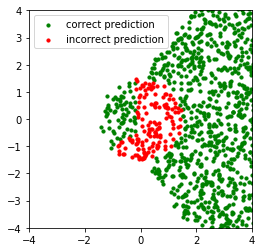

---------- Training SM_DP ----------
Added pepper=0.1 random negatives on 3/3 LFs

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
  )
  (2): Sequential(
    (0): Linear(in_features=5, out_features=5, bias=True)
    (1): ReLU()
  )
  (3): Linear(in_features=5, out_features=2, bias=True)
)

Default to SliceMaster
Resetting base model parameters
SliceMaster(
  (body): Sequential(
    (0): IdentityModule()
    (1): Sequential(
      (0): Linear(in_features=2, out_features=5, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=5, out_features=5, bias=True)
      (1): ReLU()
    )
  )
  (L_head): Linear(in_features=5, out_features=3, bias=False)
  (L_criteria): BCEWithLogitsLoss()
  (Y_head_off): Linear(in_features=5, out_features=1, bias=True)
  (Y_criteria): BCEWithLogitsLoss()
)

[1 epo]: TRAIN:[loss=14.096] VALID:[slice_1=0.915, slice_2=0.907, accuracy

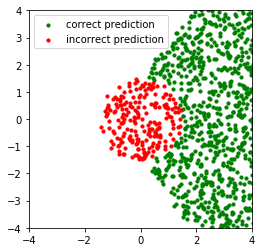

---------- Training SM_ON ----------
Added pepper=0.1 random negatives on 3/3 LFs

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
  )
  (2): Sequential(
    (0): Linear(in_features=5, out_features=5, bias=True)
    (1): ReLU()
  )
  (3): Linear(in_features=5, out_features=2, bias=True)
)

Default to SliceMaster
Resetting base model parameters
SliceMaster(
  (body): Sequential(
    (0): IdentityModule()
    (1): Sequential(
      (0): Linear(in_features=2, out_features=5, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=5, out_features=5, bias=True)
      (1): ReLU()
    )
  )
  (L_head): Linear(in_features=5, out_features=3, bias=False)
  (L_criteria): BCEWithLogitsLoss()
  (Y_head_off): Linear(in_features=5, out_features=1, bias=True)
  (Y_criteria): BCEWithLogitsLoss()
  (Y_head_on): Linear(in_features=5, out_features=1, bias=True)
)

[1 epo]: T

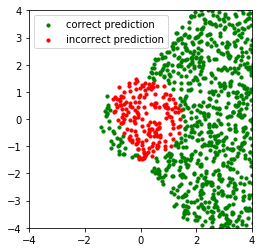

CPU times: user 1h 6min 59s, sys: 30.4 s, total: 1h 7min 29s
Wall time: 6min 7s


In [8]:
%%time
from collections import defaultdict

from metal.label_model import MajorityLabelVoter
from metal.utils import split_data
from metal.contrib.backends.snorkel_gm_wrapper import SnorkelLabelModel
from metal.contrib.slicing.experiment_utils import (
    create_data_loader,
    train_model,
    train_slice_dp,
    search_upweighting_models,
    eval_model
)
from metal.contrib.slicing.utils import get_L_weights_from_targeting_lfs_idx
from metal.contrib.slicing.mixture_of_experts import train_MoE_model


model_configs = {
#     "UNI": uni_config,
#     "UP": up_config,
#     "MoE": moe_config,
    "DP": base_dp_config,
    'SM_DP': sm_dp_config,
    "SM_ON": sm_on_config,
}

NUM_TRIALS = 3
NUM_SLICES = 4
K = 2
M = 10
N = 5000
unipolar = False
pepper = 0.1
# A base to add to trial number to set a unique seed for each trial
# salt = np.random.randint(1e6)
salt = 918880

print(f"Salt: {salt}")
if pepper:
    print(f"Pepper: {pepper}")

    
Z_kwargs = {'num_slices': NUM_SLICES}
X, Y, C, L = generate_pacman_data(config)

Ls, Xs, Ys, Zs = split_data(L, X, Y, Z, splits=[0.5, 0.25, 0.25], shuffle=True)
L_train_raw = Ls[0].copy() # TEMP
    
history = defaultdict(list)
for trial in range(NUM_TRIALS):
    print(f"[Trial {trial}]")
    
    for model_name, model_config in model_configs.items():
        print ("-"*10, "Training", model_name, "-"*10)

        Ls[0] = L_train_raw.copy() # TEMP: Reset to unpeppered version
        
        # Generate weak labels:
        if model_name == "UNI":
            Y_train = MajorityLabelVoter().predict_proba(Ls[0])
        else:
            label_model = SnorkelLabelModel()
            label_model.train_model(Ls[0])
            Y_train = label_model.predict_proba(Ls[0])
        Ys[0] = Y_train
        
        from metal.contrib.slicing.utils import add_pepper
        Ls[0] = add_pepper(Ls[0], pepper)        
        
        # Train end model
        if model_name == "UNI":
            model = train_model(model_config, Ls, Xs, Ys, Zs)
        elif model_name == 'UP':
            # generates weighted Y_train and overwrites overwrites Ys[0] internally
            model = search_upweighting_models(model_config, Ls, Xs, Ys, Zs, 
                                              targeting_lfs_idx, verbose=False)
        elif model_name == "MoE":
            model = train_MoE_model(model_config, Ls, Xs, Ys, Zs)
        else:
            model = train_model(model_config, Ls, Xs, Ys, Zs)
            
        test_loader = create_data_loader(Ls, Xs, Ys, Zs, model_config, 'test')
        results = eval_model(model, test_loader, verbose=False, summary=False)    
        
        plt.figure(figsize=(4, 4))
        plot_predictions(model, test_loader, C=None)
        plt.show()
        
        # Save results
        history[model_name].append(results)

In [9]:
from metal.contrib.slicing.experiment_utils import parse_history

print(f"Average (n={NUM_TRIALS}):")
df = parse_history(history, 2)
df

Average (n=3):


,DP,SM_DP,SM_ON
all,0.932258,0.941222,0.933410
slice_0,0.926101,0.940252,0.929245
slice_1,0.932229,0.940588,0.933124
slice_2,0.940928,0.951477,0.943038
slice_avg,0.933086,0.944106,0.935136
